# Bayesian Optimization of CNN with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up a simple CNN
- Set up the hyperparameter search shape
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [ ]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [1]:
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [3]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [6]:
# Load the data

#data = pd.read_csv("../mnist.csv")
data = pd.read_csv("../data/train.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

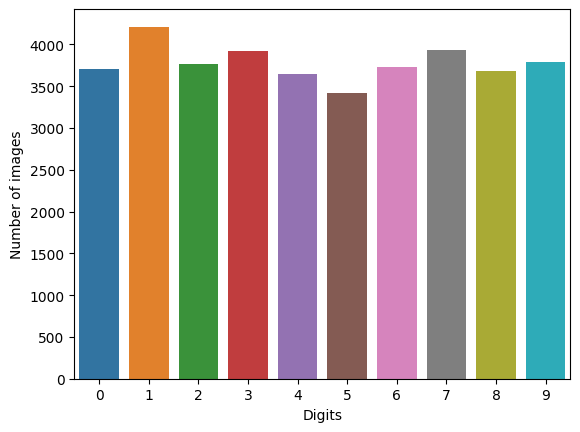

In [8]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [9]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [10]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [11]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [12]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

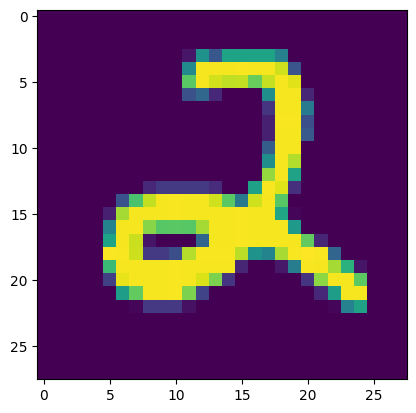

In [13]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

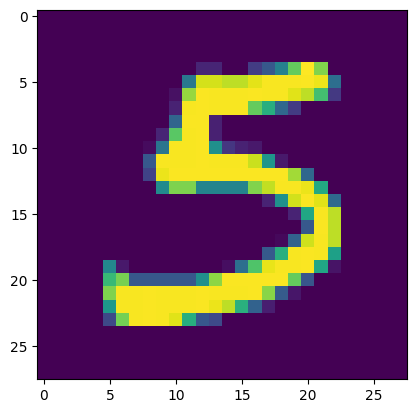

In [14]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers.

In fact, the number of fully-connected Dense layers and the number of Neurons in each one of the Dense layers, are some of the hyperparameters we want to optimize.

We could also optimize the number of Convolutional layers. But we will keep that for later, and here we keep it a bit simpler.

In [ ]:
# function to create the CNN
# we pass the hyperparameters we want to optimize
# and the function returns the model (compiled with the optimizer)
# inside the function the model is defined
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function only.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(learning_rate=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [ ]:
# We define the hyperparameter space
dim_learning_rate = Real(
    low=1e-6,
    high=1e-2,
    prior='log-uniform', # sample it from teh log-uniform distribution
    name='learning_rate',
)

# uniformly sampled by default
dim_num_dense_layers = Integer(low=1,
                               high=5,
                               name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [ ]:
# the hyperparameter space grid
param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]
# NOTE: other possible hyperparameters: batch size, epochs, number of convolutional layers in each conv-pool block, etc.

# Define the Objective Function

In [22]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [26]:
# The objective function in the case of a neural network does the following:
# - Instantiate a model with a set of hyperparameters: create_cnn()
# - Instantiate anything required by the model, e.g., learning rate reduction scheme
# - Fit/train it for some epoches and a given fraction of validation split
# - If the score is the best so far, save the model and its training statistics
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3, # 3
                        batch_size=128, # this could be a hyperparameter, too
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # VERY IMPORTANT!
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [24]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.
# Beware of the time needed for one evaluation and
# modify epochs and n_calls accordingly
default_parameters = [1e-5, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 33s 120ms/step - loss: 2.2733 - accuracy: 0.1655 - val_loss: 2.2337 - val_accuracy: 0.2228 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 30s 115ms/step - loss: 2.1717 - accuracy: 0.2722 - val_loss: 2.1013 - val_accuracy: 0.3574 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 31s 116ms/step - loss: 2.0007 - accuracy: 0.4185 - val_loss: 1.8971 - val_accuracy: 0.4865 - lr: 1.0000e-05

Accuracy: 48.65%



-0.48650792241096497

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization

In [27]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel
# NOTE: instead of passing n_initial_points, we pass
# th einitial parameters!
gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 33s 118ms/step - loss: 2.2509 - accuracy: 0.1392 - val_loss: 2.1818 - val_accuracy: 0.1974 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 31s 116ms/step - loss: 2.0844 - accuracy: 0.3132 - val_loss: 1.9869 - val_accuracy: 0.4013 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 31s 115ms/step - loss: 1.8494 - accuracy: 0.4855 - val_loss: 1.7293 - val_accuracy: 0.5156 - lr: 1.0000e-05

Accuracy: 51.56%

learning rate: 2.4e-04
num_dense_layers: 4
num_dense_nodes: 440
activation: sigmoid

Epoch 1/3
266/266 [==============================] - 55s 199ms/step - loss: 2.3126 - accuracy: 0.1023 - val_loss: 2.3037 - val_accuracy: 0.1146 - lr: 2.3517e-04
Epoch 2/3
266/266 [==============================] - 53s 198ms/step - loss: 1.8397 - accuracy: 0.3313 - val_loss: 0.8857 - val_accuracy: 0.6786 - lr: 2.3517e-04
Epoch 3/3


C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 41s 148ms/step - loss: 2.3165 - accuracy: 0.1086 - val_loss: 2.2266 - val_accuracy: 0.2093 - lr: 5.2951e-04
Epoch 2/3
266/266 [==============================] - 40s 149ms/step - loss: 1.0674 - accuracy: 0.6094 - val_loss: 0.5569 - val_accuracy: 0.7968 - lr: 5.2951e-04
Epoch 3/3
266/266 [==============================] - 40s 150ms/step - loss: 0.4414 - accuracy: 0.8533 - val_loss: 0.3980 - val_accuracy: 0.8646 - lr: 5.2951e-04

Accuracy: 86.46%

learning rate: 5.7e-04
num_dense_layers: 1
num_dense_nodes: 160
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 31s 112ms/step - loss: 0.3680 - accuracy: 0.8935 - val_loss: 0.1369 - val_accuracy: 0.9587 - lr: 5.7476e-04
Epoch 2/3
266/266 [==============================] - 28s 106ms/step - loss: 0.0923 - accuracy: 0.9720 - val_loss: 0.0864 - val_accuracy: 0.9767 - lr: 5.7476e-04
Epoch 3/3
266/266 [==============================] - 27s 103ms/step - loss: 0.0626 - accuracy: 0.9804 - val_loss: 0.0785 - val_accuracy: 0.9796 - lr: 5.7476e-04

Accuracy: 97.96%

learning rate: 2.4e-03
num_dense_layers: 5
num_dense_nodes: 5
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 29s 102ms/step - loss: 1.3111 - accuracy: 0.5191 - val_loss: 0.5586 - val_accuracy: 0.8087 - lr: 0.0024
Epoch 2/3
266/266 [==============================] - 27s 102ms/step - loss: 0.4239 - accuracy: 0.8525 - val_loss: 0.3365 - val_accuracy: 0.9008 - lr: 0.0024
Epoch 3/3
266/266 [==============================] - 26s 100ms/step - loss: 0.2401 - accuracy: 0.9304 - val_loss: 0.2157 - val_accuracy: 0.9415 - lr: 0.0024

Accuracy: 94.15%

learning rate: 8.2e-04
num_dense_layers: 4
num_dense_nodes: 79
activation: sigmoid



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 31s 111ms/step - loss: 2.3086 - accuracy: 0.1040 - val_loss: 2.3090 - val_accuracy: 0.0997 - lr: 8.1990e-04
Epoch 2/3
266/266 [==============================] - 40s 151ms/step - loss: 2.3050 - accuracy: 0.1024 - val_loss: 2.3042 - val_accuracy: 0.0997 - lr: 8.1990e-04
Epoch 3/3
266/266 [==============================] - 35s 130ms/step - loss: 2.3042 - accuracy: 0.1050 - val_loss: 2.3035 - val_accuracy: 0.1045 - lr: 8.1990e-04

Accuracy: 10.45%

learning rate: 1.5e-03
num_dense_layers: 2
num_dense_nodes: 354
activation: sigmoid



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 38s 138ms/step - loss: 1.4988 - accuracy: 0.4577 - val_loss: 0.2878 - val_accuracy: 0.9119 - lr: 0.0015
Epoch 2/3
266/266 [==============================] - 34s 127ms/step - loss: 0.1826 - accuracy: 0.9427 - val_loss: 0.1417 - val_accuracy: 0.9598 - lr: 0.0015
Epoch 3/3
266/266 [==============================] - 36s 134ms/step - loss: 0.1024 - accuracy: 0.9670 - val_loss: 0.1019 - val_accuracy: 0.9698 - lr: 0.0015

Accuracy: 96.98%

learning rate: 1.6e-04
num_dense_layers: 3
num_dense_nodes: 324
activation: relu

Epoch 1/3


C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 35s 129ms/step - loss: 0.6020 - accuracy: 0.8383 - val_loss: 0.2281 - val_accuracy: 0.9331 - lr: 1.5597e-04
Epoch 2/3
266/266 [==============================] - 32s 121ms/step - loss: 0.1613 - accuracy: 0.9512 - val_loss: 0.1574 - val_accuracy: 0.9532 - lr: 1.5597e-04
Epoch 3/3
266/266 [==============================] - 32s 121ms/step - loss: 0.1014 - accuracy: 0.9687 - val_loss: 0.1146 - val_accuracy: 0.9675 - lr: 1.5597e-04

Accuracy: 96.75%

learning rate: 6.1e-03
num_dense_layers: 5
num_dense_nodes: 171
activation: relu

Epoch 1/3


C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 33s 122ms/step - loss: 0.4188 - accuracy: 0.8546 - val_loss: 0.1084 - val_accuracy: 0.9698 - lr: 0.0061
Epoch 2/3
266/266 [==============================] - 37s 138ms/step - loss: 0.0896 - accuracy: 0.9754 - val_loss: 0.0892 - val_accuracy: 0.9765 - lr: 0.0061
Epoch 3/3
266/266 [==============================] - 34s 129ms/step - loss: 0.0686 - accuracy: 0.9818 - val_loss: 0.0808 - val_accuracy: 0.9804 - lr: 0.0061

Accuracy: 98.04%

learning rate: 1.9e-03
num_dense_layers: 4
num_dense_nodes: 328
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 39s 140ms/step - loss: 0.2288 - accuracy: 0.9253 - val_loss: 0.0849 - val_accuracy: 0.9759 - lr: 0.0019
Epoch 2/3
266/266 [==============================] - 39s 147ms/step - loss: 0.0590 - accuracy: 0.9820 - val_loss: 0.0824 - val_accuracy: 0.9802 - lr: 0.0019
Epoch 3/3
266/266 [==============================] - 42s 157ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.0857 - val_accuracy: 0.9794 - lr: 0.0019

Accuracy: 97.94%

learning rate: 7.8e-03
num_dense_layers: 5
num_dense_nodes: 402
activation: sigmoid



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 47s 171ms/step - loss: 2.3433 - accuracy: 0.1017 - val_loss: 2.3006 - val_accuracy: 0.1146 - lr: 0.0078
Epoch 2/3
266/266 [==============================] - 40s 151ms/step - loss: 2.3023 - accuracy: 0.1054 - val_loss: 2.3017 - val_accuracy: 0.0997 - lr: 0.0078
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3021 - accuracy: 0.1091
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0038797773886471987.
266/266 [==============================] - 56s 210ms/step - loss: 2.3021 - accuracy: 0.1091 - val_loss: 2.3007 - val_accuracy: 0.1146 - lr: 0.0078

Accuracy: 11.46%

learning rate: 1.1e-03
num_dense_layers: 3
num_dense_nodes: 498
activation: sigmoid



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 45s 161ms/step - loss: 1.9829 - accuracy: 0.2514 - val_loss: 0.8176 - val_accuracy: 0.6987 - lr: 0.0011
Epoch 2/3
266/266 [==============================] - 47s 176ms/step - loss: 0.4994 - accuracy: 0.8319 - val_loss: 0.3022 - val_accuracy: 0.9045 - lr: 0.0011
Epoch 3/3
266/266 [==============================] - 44s 164ms/step - loss: 0.2405 - accuracy: 0.9237 - val_loss: 0.2130 - val_accuracy: 0.9336 - lr: 0.0011

Accuracy: 93.36%

learning rate: 7.7e-04
num_dense_layers: 1
num_dense_nodes: 372
activation: sigmoid



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 37s 133ms/step - loss: 1.9165 - accuracy: 0.3137 - val_loss: 0.6493 - val_accuracy: 0.8106 - lr: 7.7085e-04
Epoch 2/3
266/266 [==============================] - 35s 132ms/step - loss: 0.4123 - accuracy: 0.8780 - val_loss: 0.3000 - val_accuracy: 0.9127 - lr: 7.7085e-04
Epoch 3/3
266/266 [==============================] - 43s 162ms/step - loss: 0.2376 - accuracy: 0.9291 - val_loss: 0.2349 - val_accuracy: 0.9294 - lr: 7.7085e-04

Accuracy: 92.94%

learning rate: 3.3e-03
num_dense_layers: 3
num_dense_nodes: 147
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 45s 162ms/step - loss: 0.2159 - accuracy: 0.9294 - val_loss: 0.0799 - val_accuracy: 0.9770 - lr: 0.0033
Epoch 2/3
266/266 [==============================] - 36s 133ms/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.0579 - val_accuracy: 0.9833 - lr: 0.0033
Epoch 3/3
266/266 [==============================] - 36s 135ms/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.0522 - val_accuracy: 0.9841 - lr: 0.0033

Accuracy: 98.41%

learning rate: 1.0e-02
num_dense_layers: 2
num_dense_nodes: 292
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 43s 156ms/step - loss: 0.2397 - accuracy: 0.9236 - val_loss: 0.0882 - val_accuracy: 0.9746 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 33s 125ms/step - loss: 0.0713 - accuracy: 0.9785 - val_loss: 0.0768 - val_accuracy: 0.9765 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 32s 122ms/step - loss: 0.0610 - accuracy: 0.9822 - val_loss: 0.1003 - val_accuracy: 0.9738 - lr: 0.0100

Accuracy: 97.38%

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 249
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 37s 134ms/step - loss: 0.2507 - accuracy: 0.9203 - val_loss: 0.0718 - val_accuracy: 0.9783 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 37s 139ms/step - loss: 0.0678 - accuracy: 0.9778 - val_loss: 0.0793 - val_accuracy: 0.9767 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9843
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
266/266 [==============================] - 40s 150ms/step - loss: 0.0491 - accuracy: 0.9843 - val_loss: 0.0780 - val_accuracy: 0.9778 - lr: 0.0100

Accuracy: 97.78%

learning rate: 4.7e-04
num_dense_layers: 1
num_dense_nodes: 512
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 65s 239ms/step - loss: 0.3627 - accuracy: 0.8962 - val_loss: 0.1362 - val_accuracy: 0.9601 - lr: 4.6590e-04
Epoch 2/3
266/266 [==============================] - 43s 163ms/step - loss: 0.0888 - accuracy: 0.9732 - val_loss: 0.0852 - val_accuracy: 0.9751 - lr: 4.6590e-04
Epoch 3/3
266/266 [==============================] - 35s 132ms/step - loss: 0.0583 - accuracy: 0.9819 - val_loss: 0.0680 - val_accuracy: 0.9804 - lr: 4.6590e-04

Accuracy: 98.04%

learning rate: 5.9e-03
num_dense_layers: 1
num_dense_nodes: 512
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 44s 162ms/step - loss: 0.1989 - accuracy: 0.9389 - val_loss: 0.0893 - val_accuracy: 0.9714 - lr: 0.0059
Epoch 2/3
266/266 [==============================] - 40s 150ms/step - loss: 0.0542 - accuracy: 0.9824 - val_loss: 0.0639 - val_accuracy: 0.9828 - lr: 0.0059
Epoch 3/3
266/266 [==============================] - 41s 153ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0592 - val_accuracy: 0.9849 - lr: 0.0059

Accuracy: 98.49%

learning rate: 1.0e-02
num_dense_layers: 4
num_dense_nodes: 104
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 36s 129ms/step - loss: 0.3917 - accuracy: 0.8708 - val_loss: 0.1408 - val_accuracy: 0.9606 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 38s 141ms/step - loss: 0.0981 - accuracy: 0.9725 - val_loss: 0.0979 - val_accuracy: 0.9728 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 33s 123ms/step - loss: 0.0815 - accuracy: 0.9776 - val_loss: 0.0945 - val_accuracy: 0.9778 - lr: 0.0100

Accuracy: 97.78%

learning rate: 7.1e-05
num_dense_layers: 5
num_dense_nodes: 512
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 44s 160ms/step - loss: 0.7740 - accuracy: 0.7972 - val_loss: 0.2464 - val_accuracy: 0.9243 - lr: 7.0915e-05
Epoch 2/3
266/266 [==============================] - 40s 150ms/step - loss: 0.1793 - accuracy: 0.9442 - val_loss: 0.1489 - val_accuracy: 0.9571 - lr: 7.0915e-05
Epoch 3/3
266/266 [==============================] - 40s 152ms/step - loss: 0.1142 - accuracy: 0.9647 - val_loss: 0.1090 - val_accuracy: 0.9706 - lr: 7.0915e-05

Accuracy: 97.06%

learning rate: 1.8e-03
num_dense_layers: 3
num_dense_nodes: 512
activation: relu



C:\Users\msagardi\AppData\Local\anaconda3\envs\hyp\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 43s 155ms/step - loss: 0.2104 - accuracy: 0.9317 - val_loss: 0.0591 - val_accuracy: 0.9823 - lr: 0.0018
Epoch 2/3
266/266 [==============================] - 38s 143ms/step - loss: 0.0547 - accuracy: 0.9842 - val_loss: 0.0658 - val_accuracy: 0.9807 - lr: 0.0018
Epoch 3/3
266/266 [==============================] - 37s 138ms/step - loss: 0.0376 - accuracy: 0.9880 - val_loss: 0.0543 - val_accuracy: 0.9844 - lr: 0.0018

Accuracy: 98.44%



# Analyze results

In [28]:
# function value at the minimum.
# note that it is the negative of the accuracy
"Best score=%.4f" % gp_.fun

'Best score=-0.9849'

In [29]:
gp_.x

[0.005900825324062468, 1, 512, 'relu']

In [30]:
# we can access the hyperparameter space
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=5, high=512, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [31]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- learning rate=0.005901
- num_dense_layers=1
- num_nodes=512
- activation = relu


## Convergence

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

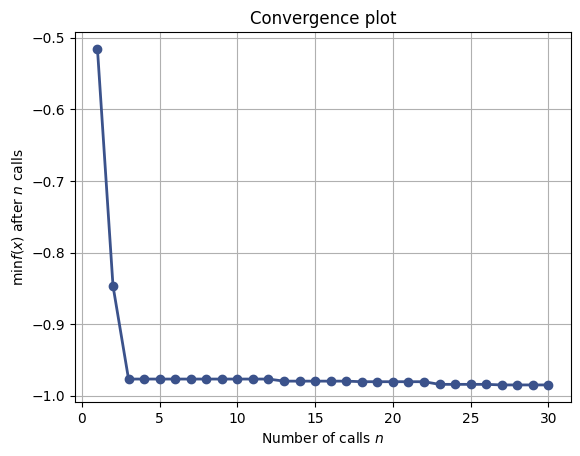

In [32]:
# Always plot the convergence to check whether we founf the minimum
plot_convergence(gp_)

## Partially dependency plots

[plot_objective](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective)

In [33]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

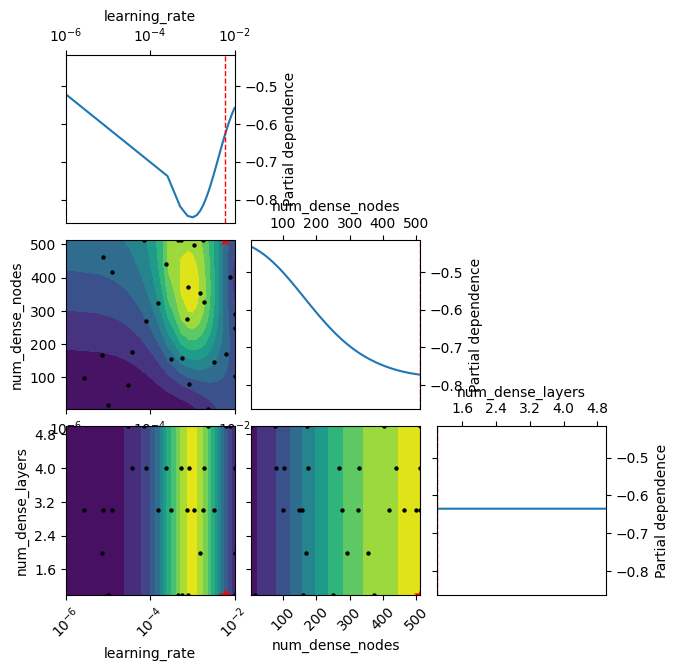

In [34]:
# Objective plot:
# We select the hyperparameters we want to analyze
# A matrix of plots is shown
# The diagonal shows the effect of each selected hyperparam on the response
# The non-diagonal plots are bi-variate plots of pairs of hyperparams
# and they also show the effect of varying hyperparam values on the response.
# In black, the sampled combinations, in red, the optimum combination (minimum response in objective)
# We see that sometimes some hyperparams have no effect, e.g., number of dense layers
# https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

## Evaluation order

[plot_evaluations](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html)

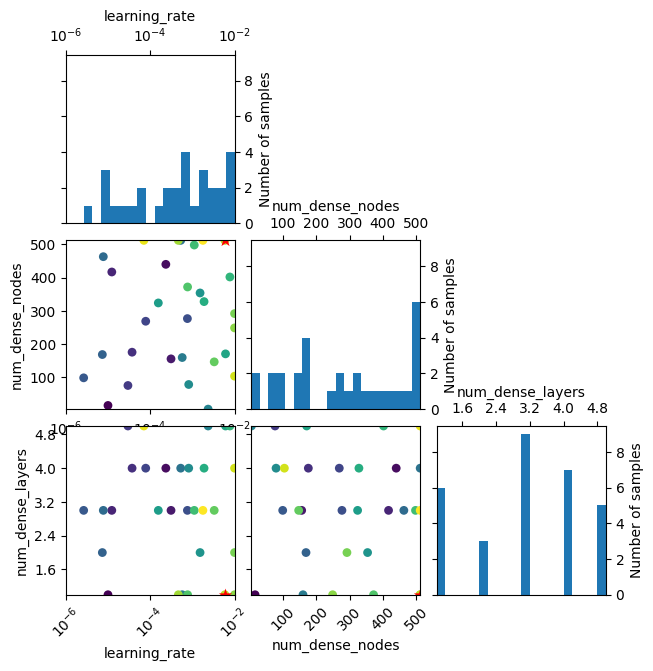

In [35]:
# Evaluations plot
# We select the hyperparameters we want to analyze
# A matrix of plots is shown
# The diagonal shows the histogram of samplings for each selected hyperparam
# The non-diagonal plots show the order of the sampling with pairs of hyperparams
# The order in which hyperparams were sampled is color-coded
# The optimum point is in red
# https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

# Evaluate the model

In [36]:
# We need to evaluate the final/best model with the test set
# For that, we load the best model
model = load_model(path_best_model)

In [37]:
# make predictions in test set
# NOTE: there is actually another dataset we could use...
# but we use the split we created.
result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 2s 13ms/step - loss: 0.0494 - accuracy: 0.9840


In [38]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.049428313970565796
accuracy 0.9840475916862488


## Confusion matrix

In [39]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 2s 11ms/step


array([[419,   0,   0,   0,   0,   0,   2,   0,   1,   0],
       [  0, 468,   0,   0,   0,   0,   1,   2,   2,   0],
       [  2,   0, 400,   1,   1,   0,   1,   4,   0,   0],
       [  0,   0,   2, 422,   0,   1,   0,   1,   0,   0],
       [  1,   2,   0,   0, 421,   1,   1,   0,   0,   3],
       [  0,   0,   0,   1,   0, 376,   3,   0,   2,   0],
       [  0,   0,   0,   0,   1,   0, 411,   0,   0,   0],
       [  1,   1,   6,   1,   1,   2,   0, 454,   0,   3],
       [  0,   1,   1,   0,   0,   0,   5,   0, 377,   0],
       [  2,   0,   0,   0,   5,   1,   0,   0,   1, 385]], dtype=int64)

Text(0.5, 21.34715460257995, 'Predicted label')

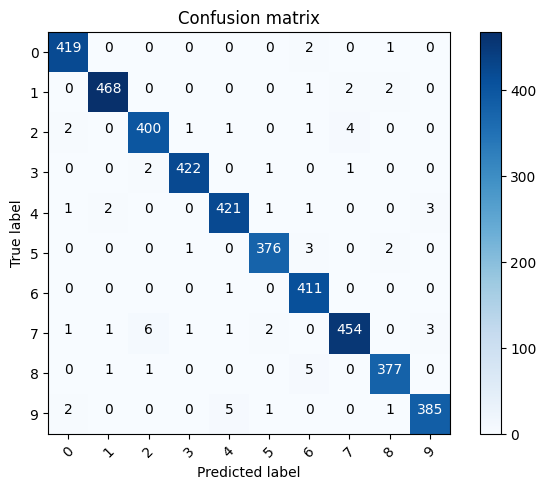

In [40]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

#  References

This notebook was based on these resources:

- [TensorFlow Tutorial #19](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb)
- [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
- [Keras](https://keras.io/)